In [1]:
import sys
sys.path.append("..")

In [2]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Get distribution of frame spans for words and phonemes according to state trajectory spec
with open("../out/state_space_specs/all_words.pkl", "rb") as f:
    word_trajectory_spec = pickle.load(f)
with open("../out/state_space_specs/all_phonemes_by_identity.pkl", "rb") as f:
    phoneme_trajectory_spec = pickle.load(f)
with open("../out/state_space_specs/all_syllables.pkl", "rb") as f:
    syllable_trajectory_spec = pickle.load(f)

In [4]:
word_frame_durations = pd.Series([end - start for frame_spans in word_trajectory_spec.target_frame_spans for start, end in frame_spans])
phoneme_frame_durations = pd.Series([end - start for frame_spans in phoneme_trajectory_spec.target_frame_spans for start, end in frame_spans])
syllable_frame_durations = pd.Series([end - start for frame_spans in syllable_trajectory_spec.target_frame_spans for start, end in frame_spans])

In [5]:
lengths_df = pd.concat([word_frame_durations, phoneme_frame_durations, syllable_frame_durations],
                       keys=["word", "phoneme", "syllable"], names=["unit"]).rename("length")

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Frame length distribution')

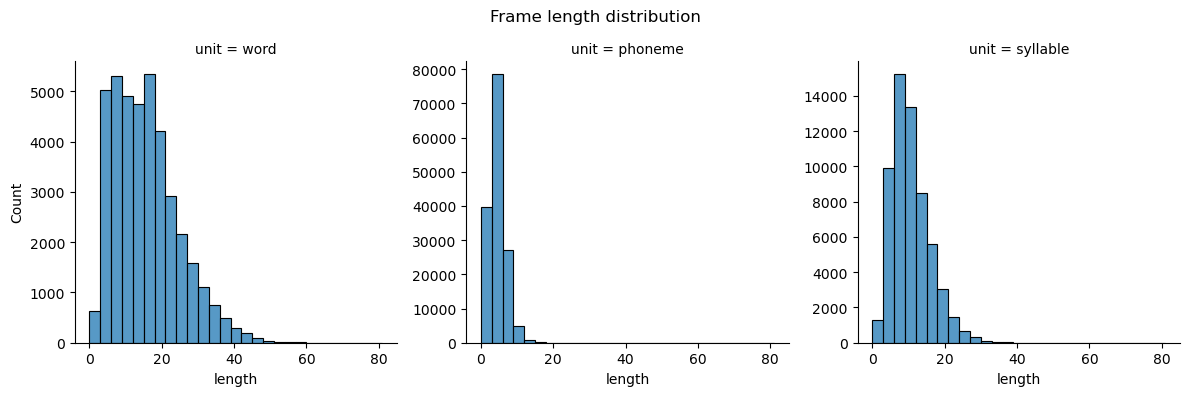

In [6]:
g = sns.displot(
    lengths_df.reset_index(), x="length", col="unit", col_wrap=3,
    binwidth=3, height=4, facet_kws=dict(margin_titles=True, sharey=False),
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Frame length distribution")

In [7]:
length_outlier_boundary = lengths_df.groupby("unit").apply(lambda xs: np.percentile(xs, 90))
length_outlier_boundary

unit
phoneme      7.0
syllable    17.0
word        28.0
Name: length, dtype: float64

In [8]:
def baseline_coherence_measure(distance_df, unit, baseline_key="random") -> pd.DataFrame:
    # Baseline distance estimates by random equivalent
    baseline_df = {}
    for (model, equivalence), values in distance_df.groupby(["model", "equivalence"]):
        if equivalence == baseline_key:
            continue
        random_model = (model, baseline_key)
    
        values = values.set_index(["type", unit, "frame"])
        baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
        baseline_df[model, equivalence] = values.distance - baseline_values.distance

    baseline_df = pd.DataFrame(pd.concat(baseline_df, names=["model", "equivalence"]))
    return baseline_df

In [56]:
def compute_type_contrast(distance_df, type_contrasts, unit) -> pd.DataFrame:
    reindexed = distance_df.reset_index().set_index(["type", "model", "equivalence", unit, "frame"])

    if not isinstance(type_contrasts, list):
        type_contrasts = [type_contrasts]
    contrast_dfs = [(reindexed.loc[type1].distance - reindexed.loc[type2].distance)
                    for type1, type2 in type_contrasts]
    return pd.concat(contrast_dfs, names=["contrast"], keys=[f"{type1} - {type2}" for type1, type2 in type_contrasts])

## Lexical coherence

In [9]:
lexical_paths = list(Path("../outputs/notebooks").glob("**/lexical_coherence/distances.csv"))
lexical_keys, lexical_dfs = [], []
for path in lexical_paths:
    lexical_dfs.append(pd.read_csv(path))
    lexical_keys.append((path.parents[2].name, path.parents[1].name))

lexical_distance_df = pd.concat(lexical_dfs, names=["model", "equivalence"], keys=lexical_keys)
lexical_distance_df = lexical_distance_df[lexical_distance_df.frame <= length_outlier_boundary.loc["word"]]
lexical_distance_df

word  frame  distance     type
model   equivalence                                         
w2v2_32 word_suffix 0          she      0  0.026124   within
                    1          had      0  0.234051   within
                    2         your      0  0.287803   within
                    3         dark      0  0.004979   within
                    4         suit      0  0.003181   within
...                            ...    ...       ...      ...
w2v2_8  random      179573    luck     28       NaN  between
                    179574    area     28       NaN  between
                    179575   weeks     28       NaN  between
                    179576  talked     28  0.687263  between
                    179577    desk     28       NaN  between

[824992 rows x 4 columns]

In [10]:
# Plot raw data
#
# g = sns.FacetGrid(data=lexical_distance_df.reset_index(), col="type", height=6, aspect=1.25)
# g.map(sns.lineplot, "frame", "distance", "equivalence", "model")
# g.add_legend()

In [11]:
baseline_lexical_df = baseline_coherence_measure(lexical_distance_df, "word")

/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm

Text(0.5, 1.0, 'Baselined distance')

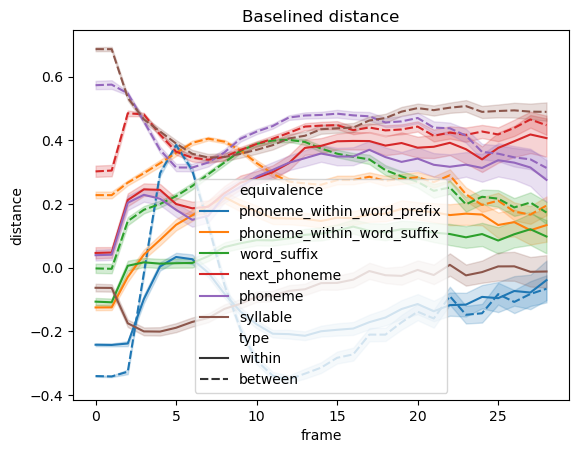

In [12]:
ax = sns.lineplot(data=baseline_lexical_df.reset_index(), x="frame", y="distance", hue="equivalence", style="type")
ax.set_title("Baselined distance")

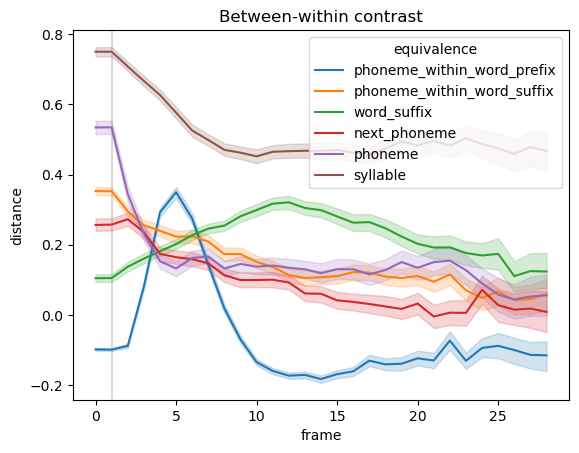

In [59]:
lexical_within_vs_between = compute_type_contrast(baseline_lexical_df, [("between", "within")], "word")
ax = sns.lineplot(data=lexical_within_vs_between.reset_index(),
                  x="frame", y="distance", hue="equivalence")
ax.set_title("Between-within contrast")
ax.axvline(1, color="gray", alpha=0.3)

## Phoneme distance

In [14]:
phoneme_paths = list(Path("../outputs/notebooks").glob("**/phoneme_coherence/distances.csv"))
phoneme_keys, phoneme_dfs = [], []
for path in phoneme_paths:
    phoneme_dfs.append(pd.read_csv(path))
    phoneme_keys.append((path.parents[2].name, path.parents[1].name))

phoneme_distance_df = pd.concat(phoneme_dfs, names=["model", "equivalence"], keys=phoneme_keys)
phoneme_distance_df = phoneme_distance_df[phoneme_distance_df.frame <= length_outlier_boundary.loc["phoneme"]]

baseline_phoneme_df = baseline_coherence_measure(phoneme_distance_df, "phoneme")
baseline_phoneme_df

/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm

distance
model   equivalence                type    phoneme frame          
w2v2_32 phoneme_within_word_prefix within  AA      0      0.167301
                                           AE      0      0.202382
                                           AH      0      0.474333
                                           AO      0      0.213945
                                           AW      0      0.279022
...                                                            ...
w2v2_8  syllable                   between W       7      1.023648
                                           Y       7           NaN
                                           Z       7           NaN
                                           ZH      7           NaN
                                           [SIL]   7           NaN

[3840 rows x 1 columns]

In [15]:
# Plot baselined data
# sns.lineplot(data=baseline_phoneme_df.reset_index(), x="frame", y="distance", hue="type", style="equivalence")

Text(0.5, 1.0, 'Between-within phoneme contrast')

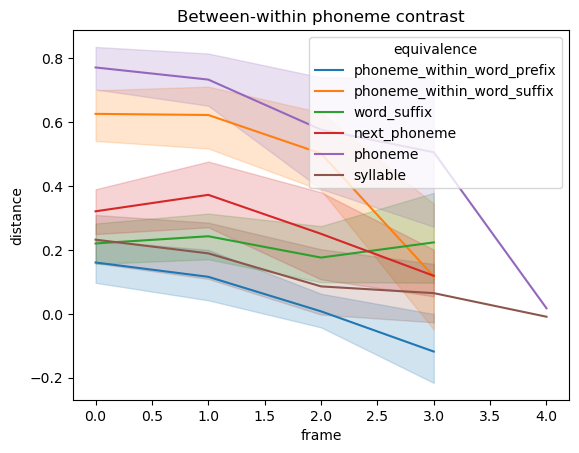

In [60]:
phoneme_within_vs_between = compute_type_contrast(baseline_phoneme_df, [("between", "within")], "phoneme")
ax = sns.lineplot(data=phoneme_within_vs_between.reset_index(),
                  x="frame", y="distance", hue="equivalence")
ax.set_title("Between-within phoneme contrast")

## Syllable distance

In [17]:
syllable_paths = list(Path("../outputs/notebooks").glob("**/syllable_coherence/distances.csv"))
syllable_keys, syllable_dfs = [], []
for path in syllable_paths:
    syllable_dfs.append(pd.read_csv(path))
    syllable_keys.append((path.parents[2].name, path.parents[1].name))

syllable_distance_df = pd.concat(syllable_dfs, names=["model", "equivalence"], keys=syllable_keys)
syllable_distance_df = syllable_distance_df[syllable_distance_df.frame <= length_outlier_boundary.loc["syllable"]]

baseline_syllable_df = baseline_coherence_measure(syllable_distance_df, "syllable")

/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm

Text(0.5, 1.0, 'Between-within syllable contrast')

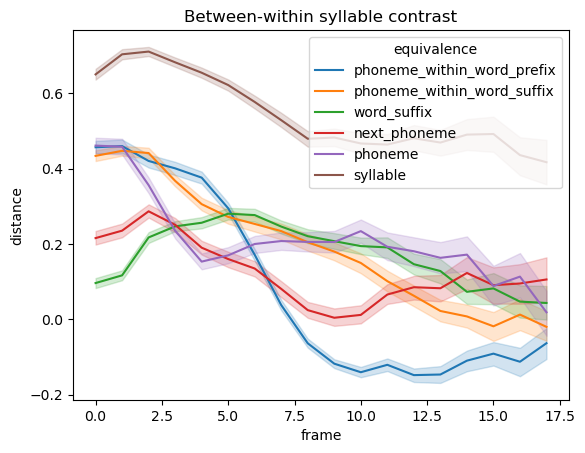

In [61]:
syllable_within_vs_between = compute_type_contrast(baseline_syllable_df, [("between", "within")], "syllable")
ax = sns.lineplot(data=syllable_within_vs_between.reset_index(),
                  x="frame", y="distance", hue="equivalence")
ax.set_title("Between-within syllable contrast")

### Syllable distance, blocked within intra-word position

In [19]:
syllable_pos_paths = list(Path("../outputs/notebooks").glob("**/syllable_coherence_by_position/distances.csv"))
syllable_pos_keys, syllable_pos_dfs = [], []
for path in syllable_pos_paths:
    syllable_pos_dfs.append(pd.read_csv(path))
    syllable_pos_keys.append((path.parents[2].name, path.parents[1].name))

syllable_pos_distance_df = pd.concat(syllable_pos_dfs, names=["model", "equivalence"], keys=syllable_pos_keys)
syllable_pos_distance_df = syllable_pos_distance_df[syllable_pos_distance_df.frame <= length_outlier_boundary.loc["syllable"]]

baseline_syllable_pos_df = baseline_coherence_measure(syllable_pos_distance_df, "syllable")
baseline_syllable_pos_df["syllable_index"] = baseline_syllable_pos_df.index.get_level_values("syllable").str.rsplit(" ", n=1).str[-1].astype(int)
baseline_syllable_pos_df

/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm0000gn/T/ipykernel_77014/1114584121.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  baseline_values = distance_df.loc[random_model].set_index(["type", unit, "frame"])
/var/folders/6c/4ff4nnfx5417_p6nsqlg4phm

distance   
model   equivalence                type    syllable frame             
w2v2_32 phoneme_within_word_prefix within  AA 0     0     -0.238182  \
                                           AA 1     0     -0.106047   
                                           AA 2     0     -0.049431   
                                           AH 0     0     -0.322681   
                                           AH 1     0     -0.051780   
...                                                             ...   
w2v2_8  syllable                   between Z IY 1   17          NaN   
                                           Z IY 2   17          NaN   
                                           ZH ER 0  17          NaN   
                                           ZH ER 1  17          NaN   
                                           ZH ER 2  17          NaN   

                                                           syllable_index  
model   equivalence                type    syllable frame                  
w2v2_32 phoneme_within_word_prefix within  AA 0     0                   0  
                                           AA 1     0                   1  
                                           AA 2     0                   2  
                                           AH 0     0                   0  
                                           AH 1     0                   1  
...                                                                   ...  
w2v2_8  syllable                   between Z IY 1   17                  1  
                                           Z IY 2   17                  2  
                                           ZH ER 0  17                  0  
                                           ZH ER 1  17                  1  
                                           ZH ER 2  17                  2  

[177876 rows x 2 columns]

<Axes: xlabel='frame', ylabel='distance'>

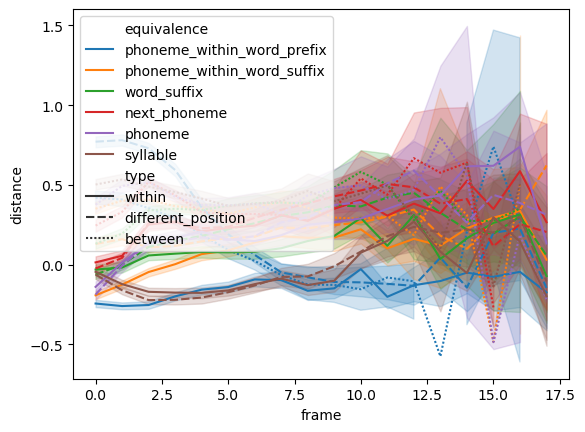

In [20]:
sns.lineplot(data=baseline_syllable_pos_df.reset_index(), x="frame", y="distance", hue="equivalence", style="type")

In [26]:
baseline_syllable_pos_df

distance   
model   equivalence                type    syllable frame             
w2v2_32 phoneme_within_word_prefix within  AA 0     0     -0.238182  \
                                           AA 1     0     -0.106047   
                                           AA 2     0     -0.049431   
                                           AH 0     0     -0.322681   
                                           AH 1     0     -0.051780   
...                                                             ...   
w2v2_8  syllable                   between Z IY 1   17          NaN   
                                           Z IY 2   17          NaN   
                                           ZH ER 0  17          NaN   
                                           ZH ER 1  17          NaN   
                                           ZH ER 2  17          NaN   

                                                           syllable_index  
model   equivalence                type    syllable frame                  
w2v2_32 phoneme_within_word_prefix within  AA 0     0                   0  
                                           AA 1     0                   1  
                                           AA 2     0                   2  
                                           AH 0     0                   0  
                                           AH 1     0                   1  
...                                                                   ...  
w2v2_8  syllable                   between Z IY 1   17                  1  
                                           Z IY 2   17                  2  
                                           ZH ER 0  17                  0  
                                           ZH ER 1  17                  1  
                                           ZH ER 2  17                  2  

[177876 rows x 2 columns]

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


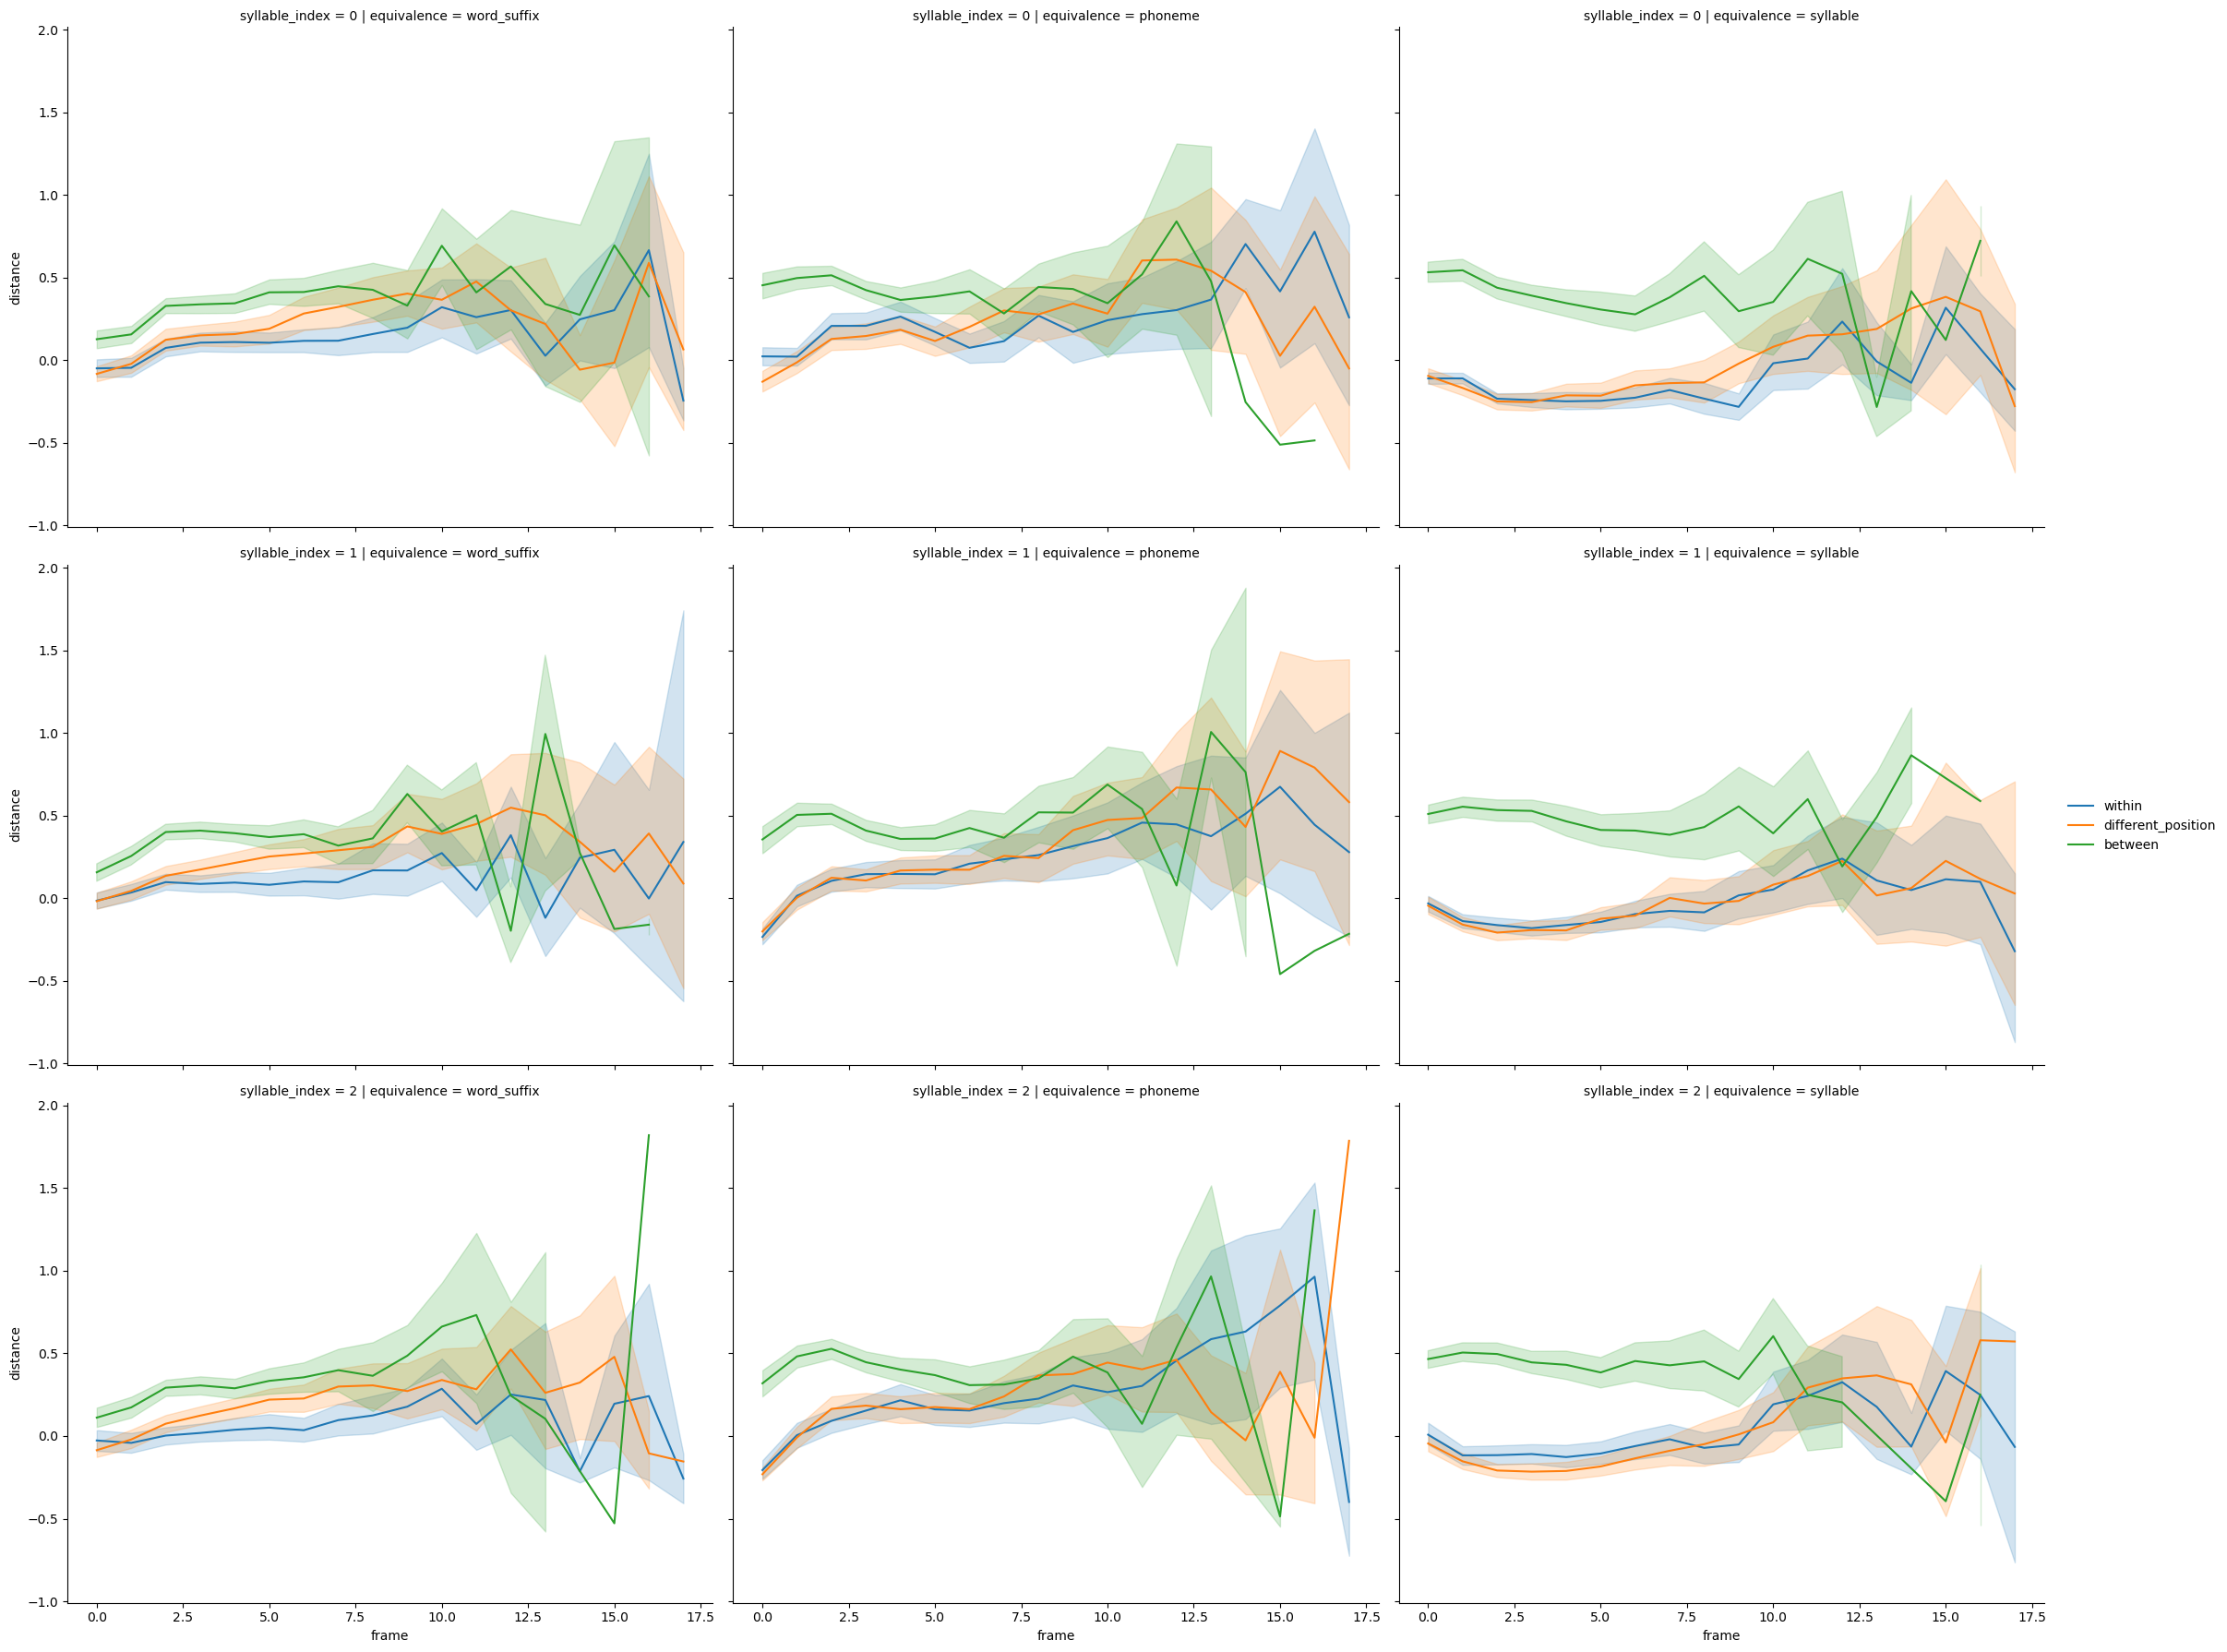

In [28]:
# plot faceted lineplot for phoneme, syllable, word_suffix equivalences
plot_subset = ["phoneme", "syllable", "word_suffix"]
g = sns.FacetGrid(data=baseline_syllable_pos_df.loc[baseline_syllable_pos_df.index.get_level_values("equivalence").isin(plot_subset)].reset_index(),
                  col="equivalence", row="syllable_index", height=6, aspect=1.25)
g.map(sns.lineplot, "frame", "distance", "type")
g.add_legend()

<Axes: xlabel='frame', ylabel='distance'>

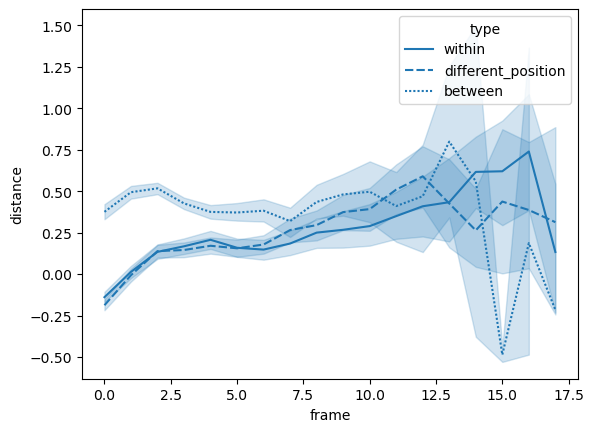

In [21]:
sns.lineplot(data=baseline_syllable_pos_df.xs("phoneme", level="equivalence").reset_index(), x="frame", y="distance", style="type")

<Axes: xlabel='frame', ylabel='distance'>

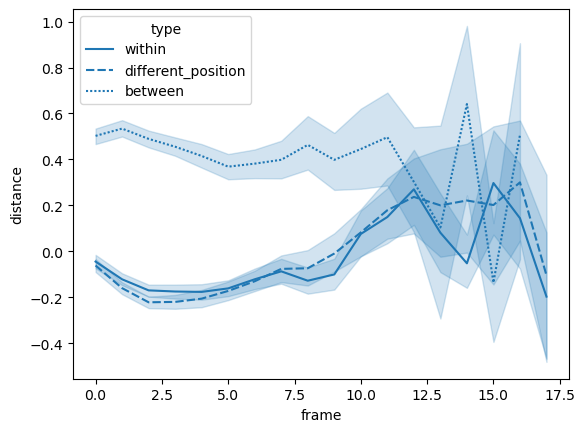

In [22]:
sns.lineplot(data=baseline_syllable_pos_df.xs("syllable", level="equivalence").reset_index(), x="frame", y="distance", style="type")

<Axes: xlabel='frame', ylabel='distance'>

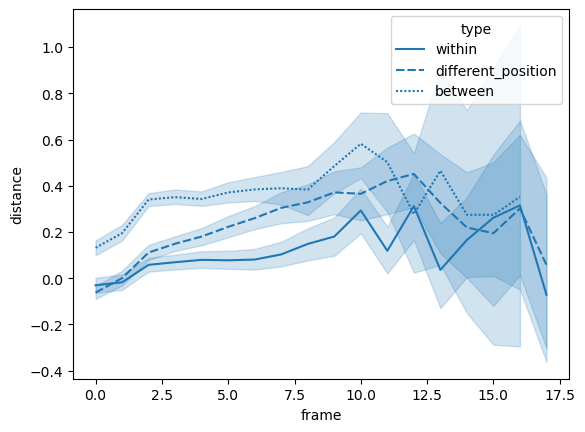

In [23]:
sns.lineplot(data=baseline_syllable_pos_df.xs("word_suffix", level="equivalence").reset_index(), x="frame", y="distance", style="type")